<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Двунаправленная-LSTM">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Двунаправленная LSTM
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративные текстовые нейросети | Двунаправленная LSTM

**Постановка задачи:** натренировать и сравнить качество нескольких генеративных текстовых моделей на одном из заданных текстовых датасетов.

**Источник данных:** [Harry Potter and the Methods of Rationality](https://hpmor.ru/).

**Характер данных:** текст книги "Гарри Поттер и методы рационального мышления".

**Основные этапы:** исследовать следующие нейросетевые архитектуры:

1. Simple RNN с посимвольной и пословной токенизацией.
2. Однонаправленная однослойная и многослойная LSTM c посимвольной токенизацией и токенизацией по словам и [на основе BPE](https://keras.io/api/keras_nlp/tokenizers/byte_pair_tokenizer/).
3. Двунаправленная LSTM.
4. *(На хорошую оценку)* трансформерная архитектура (GPT) "с нуля" [пример](https://keras.io/examples/generative/text_generation_gpt/).
5. *(На отличную оценку)* дообучение предобученной GPT-сети [пример](https://github.com/ZotovaElena/RuGPT3_finetuning).

---

# Реализации

1. [RNN с посимвольной токенизацией](RNN_char.ipynb)
2. [RNN с пословной токенизацией](RNN_word.ipynb)
3. [Однонаправленная LSTM + BPE](LSTM_unidirectional_BPE.ipynb)
4. Двунаправленная LSTM (текущий файл)
5. [Архитектура GPT](GPT_architecture.ipynb)
6. [Дообучение GPT](GPT_finetuning.ipynb)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Импорт библиотек:

In [1]:
import numpy as np

import matplotlib.pyplot as plt 

import os
import re

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import to_categorical, plot_model

from utils.useful_funcs import request_url, get_url_data, get_data, \
                               plot_performance

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Загрузка данных

Проверка наличия папки для хранения наборов данных:

In [2]:
if os.path.isdir('data/') == False:
    os.mkdir('data/')

Задание пути к файлу с основным набором данных:

In [3]:
path_file = 'data/hpmor.txt'

Формирование/загрузка набора данных в зависимости от его наличия:

In [4]:
try:
    with open(path_file, 'r', encoding='utf-8') as file:
        text = file.read()
    
    print('Uploaded from', path_file)
    
except:
    text = get_data('https://hpmor.ru/')
    
    with open(path_file, 'w', encoding='utf-8') as file:
        file.write(text)
    
    print('Saved to', path_file)

Uploaded from data/hpmor.txt


Выведение на экран начала текста:

In [5]:
text[:500]

'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду. у него были частные учителя, дискуссии с отцом, а главное — книги, сотни и тысячи научных и фантастических книг. в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами. но гарри не просто вундеркинд, у него есть загадочная тёмная сторона, которая явн'

Выведение на экран общего числа слов в тексте:

In [6]:
print('Всего слов:', len(text.split(' ')))

Всего слов: 559855


In [7]:
text_sentences = [re.sub('[^а-яА-ЯёЁ0-9 -]', '', s).strip() for s in text.split('.')]

In [8]:
text_sentences[:5]

['гарри поттер и методы рационального мышления',
 'элиезер юдковский',
 'петуния вышла замуж не за дурсля а за университетского профессора и гарри попал в гораздо более благоприятную среду',
 'у него были частные учителя дискуссии с отцом а главное  книги сотни и тысячи научных и фантастических книг',
 'в 11 лет гарри знаком с квантовой механикой когнитивной психологией теорией вероятностей и другими вещами']

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Двунаправленная LSTM

In [9]:
def get_sequences(text: list) -> list:
    input_sequences = []

    for line in text:
        token_list = tokenizer.texts_to_sequences([line])[0]

        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
            
    return input_sequences

---

In [10]:
tokenizer = Tokenizer()

In [11]:
tokenizer.fit_on_texts(text_sentences)

In [12]:
print('Всего слов:', len(tokenizer.word_index))

Всего слов: 49509


In [13]:
list(zip(list(tokenizer.word_index.keys())[:10], list(tokenizer.word_index.values())[:10]))

[('и', 1),
 ('не', 2),
 ('в', 3),
 ('что', 4),
 ('гарри', 5),
 ('на', 6),
 ('я', 7),
 ('с', 8),
 ('он', 9),
 ('это', 10)]

In [14]:
input_sequences = get_sequences(text_sentences)

In [15]:
input_sequences[:10]

[[5, 43],
 [5, 43, 1],
 [5, 43, 1, 4311],
 [5, 43, 1, 4311, 3533],
 [5, 43, 1, 4311, 3533, 1837],
 [24578, 24579],
 [2231, 2875],
 [2231, 2875, 6081],
 [2231, 2875, 6081, 2],
 [2231, 2875, 6081, 2, 26]]

In [16]:
VOCAB_LEN = len(tokenizer.word_index) + 1
MAX_SEQ_LEN = max([len(x) for x in input_sequences])
BATCH_SIZE = 100

In [17]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=MAX_SEQ_LEN, padding='pre'))

In [18]:
input_sequences[:10]

array([[   0,    0,    0, ...,    0,    5,   43],
       [   0,    0,    0, ...,    5,   43,    1],
       [   0,    0,    0, ...,   43,    1, 4311],
       ...,
       [   0,    0,    0, ..., 2231, 2875, 6081],
       [   0,    0,    0, ..., 2875, 6081,    2],
       [   0,    0,    0, ..., 6081,    2,   26]])

In [19]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = to_categorical(label, num_classes=VOCAB_LEN, dtype='int16')

In [20]:
print('', predictors[0])
print('\n', label[0])

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]

 [0 0 0 ... 0 0 0]


In [21]:
lstm = Sequential([
    Embedding(VOCAB_LEN, BATCH_SIZE, input_length=MAX_SEQ_LEN-1),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    # Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(VOCAB_LEN, activation='softmax')
])

In [23]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 240, 100)          4951000   
                                                                 
 bidirectional (Bidirectiona  (None, 240, 300)         301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 240, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 49510)             5000510   
                                                                 
Total params: 10,413,110
Trainable params: 10,413,110
Non-trainable params: 0
____________________________________________

In [24]:
if os.path.isdir('images/') == False:
    os.mkdir('images/')

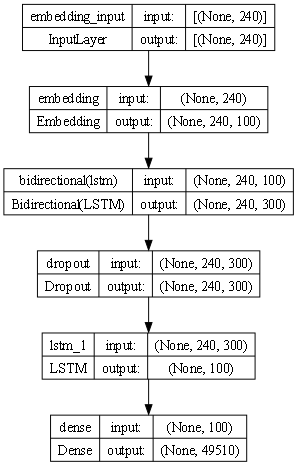

In [25]:
plot_model(lstm, 'images/lstm_model.png', show_shapes=True, dpi=70)

In [ ]:
def plot_loss_acc(history) -> None:
    font_s = 12
    plt.plot(figsize=(6,5))
    
    plt.title('Accuracy & Loss', fontsize=font_s+4)
    
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['loss'], label='loss')
    
    plt.xlabel('epoch', fontsize=font_s)
    plt.xlabel('Epoch', fontsize=font_s)
    
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

In [ ]:
if os.path.isdir('checkpoints/') == False:
    os.mkdir('checkpoints/')

In [ ]:
path_checkpoints = 'checkpoints/lstm_bi'

In [ ]:
if os.path.isdir(path_checkpoints) == False:
    os.mkdir(path_checkpoints)

In [ ]:
checkpoint_path = os.path.join(path_checkpoints, 'checkpoint_{epoch}')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

In [22]:
lstm.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = lstm.fit(predictors, label, epochs=1, verbose=1) # 100

    5/15755 [..............................] - ETA: 8:52:55 - loss: 10.8092 - accuracy: 0.0063    


KeyboardInterrupt



In [ ]:
plot_loss_acc(history)

In [ ]:
def predict_next(sample: str,
                 tokenizer: Tokenizer,
                 n_words: int,
                 max_len: int = MAX_SEQ_LEN):
    
    text_next = sample
    
    for _ in range(n_words):
        token_list = tokenizer.texts_to_sequences([text_next])[0]
        token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ''
        
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
                
        text_next += ' ' + output_word
    
    return text_next

In [ ]:
predict_next(
    sample='гарри поттер',
    tokenizer=tokenizer,
    n_words=100
)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>